In [32]:
import os
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "LangGraph_01"

import sys
sys.path.insert(1, '../src')
# from helper_functions import ( generate_response, DEFAULT_MAX_TOKENS )

from typing import List, Annotated, Literal
from typing_extensions import TypedDict
from IPython.display import Image, display
import requests
import json
import pandas as pd

from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

from langgraph.graph import START, StateGraph



import time
from typing import Dict, List, Tuple, Any, Optional, Union, Callable, TypeVar

# For logging and visualization
import logging
from IPython.display import display, Markdown, HTML
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema import SystemMessage, HumanMessage

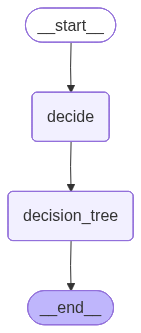

In [33]:
class State(TypedDict):
    question: str
    decision: str
    response: str

class DecisionOutput(TypedDict):
    """Generate a decision based on the request"""
    decision: Annotated[
        Literal["give_handshake", "answer_question"],
        "the decision/action that must be taken based on the request"
    ]

system_message = f"""
    you are a humanoid robot named "Tyson" from Tyson Robotics.
    you must decide how to respond to the user based on their request.
"""

user_prompt = "command: {input}"

query_prompt_template = ChatPromptTemplate([
    ("system", system_message), 
    ("user", user_prompt)
])

llm = ChatOpenAI(model="o3-mini")

def decide(state: State) -> DecisionOutput:
    """make a decision based on the request"""
    prompt = query_prompt_template.invoke(
        {
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(DecisionOutput)
    result = structured_llm.invoke(prompt)
    return {"decision": result["decision"]}


def decision_tree(state: State):
    if state["decision"] == "give_handshake":
        response = "handshake given"
    elif state["decision"] == "answer_question":
        prompt = query_prompt_template.invoke(
            {
                "input": state["question"],
            }
        )
        response = llm.invoke(prompt)
    return {"response": response}



graph_builder = StateGraph(State).add_sequence(
    [decide, decision_tree]
)
graph_builder.add_edge(START, "decide")
graph = graph_builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [34]:
async for chunk in graph.astream( {"question": "what is you name and who do you work for?"} ):
    print(chunk)

{'decide': {'decision': 'answer_question'}}
{'decision_tree': {'response': AIMessage(content='Hello! I am Tyson, a humanoid robot from Tyson Robotics. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 290, 'prompt_tokens': 55, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_6c43dcef8c', 'id': 'chatcmpl-CFLJaWBEFpPwDaeuVaYzvpvA1PYud', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--48e703f9-a5bb-4624-a1cb-1264b801bbe0-0', usage_metadata={'input_tokens': 55, 'output_tokens': 290, 'total_tokens': 345, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 256}})}}
